This runs all segmentation operations in one place.
The idea is that this should be faster and easier to invoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.
Currently it takes about 15 minutes to complete a single organoid's segmentation for all compartments... (~50,1500,1500) (Z,Y,X) dimensional image. 

In [1]:
import argparse
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import skimage
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import find_files_available, read_in_channels, read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from nuclei_segmentation import *
from read_in_channel_mapping import *
from segmentation_decoupling import *
from skimage.filters import sobel
from skimage.segmentation import relabel_sequential

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "G7-1"
    window_size = 3
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)
channel_dict = retrieve_channel_mapping(f"{root_dir}/data/channel_mapping.toml")

Running in a notebook


In [5]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict=channel_dict,
    channels_to_read=["DNA"],
)


nuclei_raw = return_dict["DNA"]
# run clip_limit here
nuclei = skimage.exposure.equalize_adapthist(
    nuclei_raw, clip_limit=clip_limit, kernel_size=None
)
del nuclei_raw

## Nuclei Segmentation

In [6]:
nuclei_image_shape = nuclei.shape
nuclei_masks = np.array(  # convert to array
    list(  # send to list
        decouple_masks(  # 4. decouple masks
            reverse_sliding_window_max_projection(  # 3. reverse sliding window
                segmentaion_on_two_D(  # 2. segment on 2D
                    sliding_window_two_point_five_D(  # 1. run sliding window
                        image_stack=nuclei, window_size=3
                    )
                ),
                window_size=3,
                original_z_slice_count=nuclei_image_shape[0],
            ),
            original_img_shape=nuclei_image_shape,
            distance_threshold=10,
        ).values()
    )
)

100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


## remove small masks in each slice

<RegionProperties: label=1, bbox=(24, 8, 1270, 25, 15, 1276)>


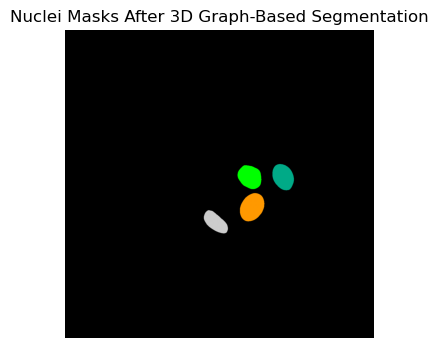

In [7]:
# Remove small objects while preserving label IDs
# we avoid using the built-in skimage function to preserve label IDs
props = skimage.measure.regionprops(nuclei_masks)

# Remove objects smaller than threshold
for prop in props:
    if prop.area < 1000:  # 10 X 10 X 10 cube equivalent to 1000 voxels
        print(prop)
        nuclei_masks[nuclei_masks == prop.label] = 0
if in_notebook:
    z = nuclei_masks.shape[0] // 4
    plt.figure(figsize=(10, 4))
    plt.imshow(nuclei_masks[z], cmap="nipy_spectral")
    plt.title("Nuclei Masks After 3D Graph-Based Segmentation")
    plt.axis("off")
    plt.show()

In [8]:
nuclei_mask, diag = full_pipeline(
    input_masks=nuclei_masks,
    max_match_distance=100,
    max_trajectory_length=12,
    verbose=False,
)

## relabel the nuclei

In [9]:
nuclei_mask, _, _ = relabel_sequential(nuclei_mask)

## Save the segmented masks

In [10]:
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
tifffile.imwrite(nuclei_mask_output, nuclei_mask)

In [ ]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")


    Memory and time profiling for the run:

    Memory usage: 3234.68 MB

    Time:

    --- %s seconds --- % 87.0731749534607

    --- %s minutes --- % 1.4512195825576781

    --- %s hours --- % 0.02418699304262797



: 